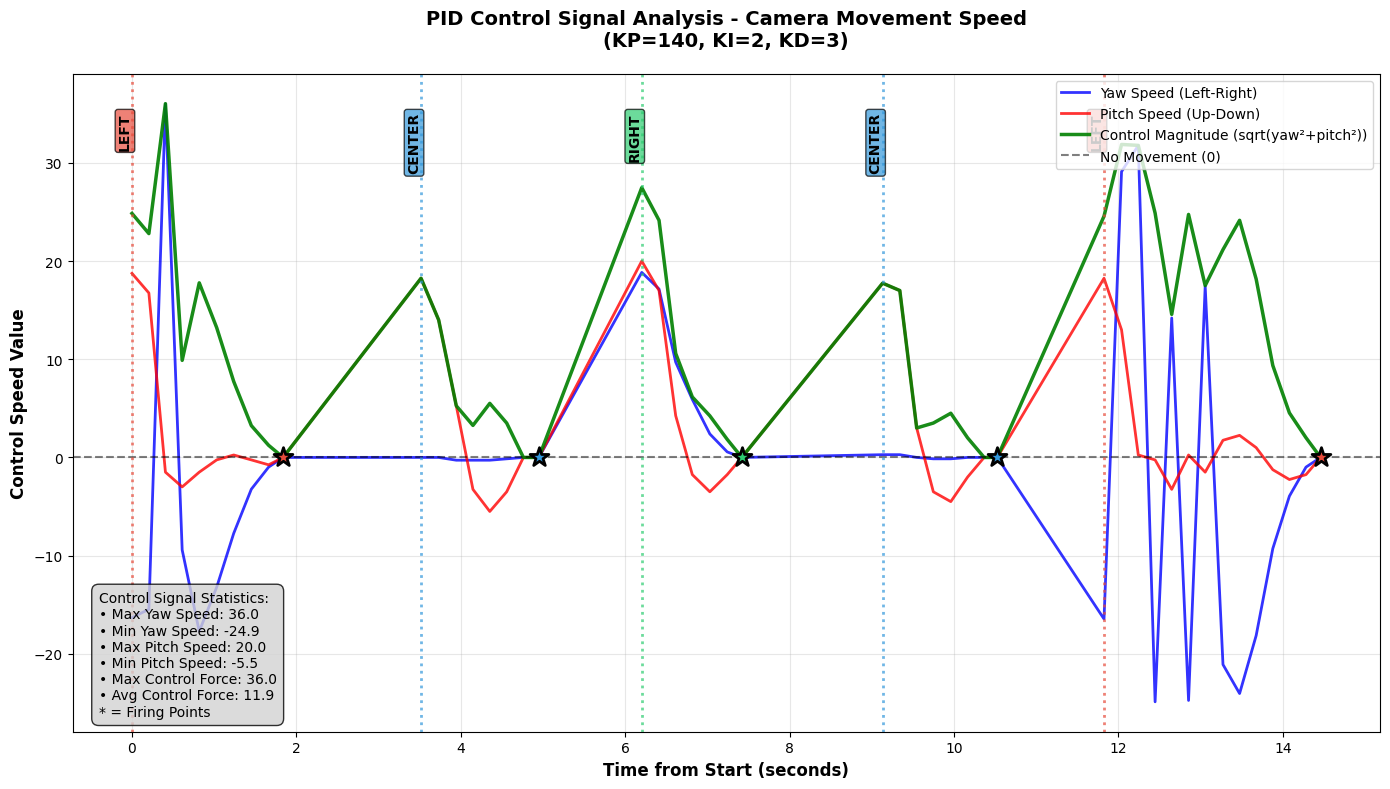

=== CONTROL SIGNAL ANALYSIS ===
PID Settings: KP=140, KI=2, KD=3
Analysis Period: 14.46 seconds

CONTROL INTENSITY:
• Yaw Speed Range: -24.89 to 36.00
• Pitch Speed Range: -5.50 to 20.00
• Average Control Magnitude: 11.88

STABILITY INDICATORS:
• Yaw Stability (σ): 13.60 (lower = more stable)
• Pitch Stability (σ): 7.71 (lower = more stable)
• Yaw Direction Changes: 19 times
• Pitch Direction Changes: 20 times

CAMERA SHAKE ASSESSMENT:
SMOOTH CONTROL: Minimal oscillation


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv(r'D:\downsyndrome\year2_1\Robot_Module_2-1\J.Thanet\Lab02\data\rec_track_1407_P180_I0_D0.csv')

# แปลง timestamp เป็น datetime และคำนวณเวลาสัมพันธ์
df['datetime'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
start_time = df['datetime'].iloc[0]
df['relative_time'] = (df['datetime'] - start_time).dt.total_seconds()

# คำนวณ control signal magnitude (ความรุนแรงรวม)
df['control_magnitude'] = np.sqrt(df['yaw_speed']**2 + df['pitch_speed']**2)

# กำหนดสีสำหรับแต่ละเป้าหมาย
target_colors = {'left': '#E74C3C', 'center': '#3498DB', 'right': '#2ECC71'}

# สร้างกราฟ
plt.figure(figsize=(14, 8))

# พลอต yaw_speed
plt.plot(df['relative_time'], df['yaw_speed'], 'b-', linewidth=2, alpha=0.8, label='Yaw Speed (Left-Right)')

# พลอต pitch_speed
plt.plot(df['relative_time'], df['pitch_speed'], 'r-', linewidth=2, alpha=0.8, label='Pitch Speed (Up-Down)')

# พลอต control magnitude
plt.plot(df['relative_time'], df['control_magnitude'], 'g-', linewidth=2.5, alpha=0.9, 
        label='Control Magnitude (sqrt(yaw²+pitch²))')

# เพิ่มเส้นอ้างอิงที่ y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No Movement (0)')

# หาจุดที่มีการเปลี่ยนเป้าหมาย
target_changes = []
current_target = None
for i, row in df.iterrows():
    if current_target != row['target_name']:
        target_changes.append((row['relative_time'], row['target_name']))
        current_target = row['target_name']

# เพิ่มเส้นแบ่งเป้าหมาย
for i, (time, target) in enumerate(target_changes):
    plt.axvline(x=time, color=target_colors[target], linestyle=':', alpha=0.7, linewidth=2)
    plt.text(time, plt.ylim()[1]*0.9, f'{target.upper()}', 
            rotation=90, ha='right', va='top', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.2", facecolor=target_colors[target], alpha=0.7))

# เพิ่มจุดที่ยิงเป้า (fired=1)
fired_points = df[df['fired'] == 1]
for _, point in fired_points.iterrows():
    plt.scatter(point['relative_time'], 0, s=200, 
            color=target_colors[point['target_name']], 
            marker='*', edgecolor='black', linewidth=2, zorder=10)

# ตั้งค่ากราฟ
plt.xlabel('Time from Start (seconds)', fontsize=12, fontweight='bold')
plt.ylabel('Control Speed Value', fontsize=12, fontweight='bold')
plt.title('PID Control Signal Analysis - Camera Movement Speed\n(KP=140, KI=2, KD=3)', 
        fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# เพิ่มข้อมูลสถิติ
stats_text = f"""Control Signal Statistics:
• Max Yaw Speed: {df['yaw_speed'].max():.1f}
• Min Yaw Speed: {df['yaw_speed'].min():.1f}
• Max Pitch Speed: {df['pitch_speed'].max():.1f}
• Min Pitch Speed: {df['pitch_speed'].min():.1f}
• Max Control Force: {df['control_magnitude'].max():.1f}
• Avg Control Force: {df['control_magnitude'].mean():.1f}
* = Firing Points"""

plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
        fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

# วิเคราะห์ความสั่นและความเสถียร
print("=== CONTROL SIGNAL ANALYSIS ===")
print(f"PID Settings: KP=140, KI=2, KD=3")
print(f"Analysis Period: {df['relative_time'].max():.2f} seconds")
print()

print("CONTROL INTENSITY:")
print(f"• Yaw Speed Range: {df['yaw_speed'].min():.2f} to {df['yaw_speed'].max():.2f}")
print(f"• Pitch Speed Range: {df['pitch_speed'].min():.2f} to {df['pitch_speed'].max():.2f}")
print(f"• Average Control Magnitude: {df['control_magnitude'].mean():.2f}")
print()

print("STABILITY INDICATORS:")
# คำนวณ standard deviation ของ control signals
yaw_std = df['yaw_speed'].std()
pitch_std = df['pitch_speed'].std()
print(f"• Yaw Stability (σ): {yaw_std:.2f} (lower = more stable)")
print(f"• Pitch Stability (σ): {pitch_std:.2f} (lower = more stable)")

# หาจำนวนครั้งที่เปลี่ยนเครื่องหมาย (การแกว่ง)
yaw_sign_changes = np.sum(np.diff(np.sign(df['yaw_speed'])) != 0)
pitch_sign_changes = np.sum(np.diff(np.sign(df['pitch_speed'])) != 0)
print(f"• Yaw Direction Changes: {yaw_sign_changes} times")
print(f"• Pitch Direction Changes: {pitch_sign_changes} times")
print()

print("CAMERA SHAKE ASSESSMENT:")
if yaw_std > 5 or pitch_std > 5:
    print("WARNING: HIGH SHAKE - Control signals are highly variable")
elif yaw_std > 2 or pitch_std > 2:
    print("CAUTION: MODERATE SHAKE - Some oscillation in control")
else:
    print("GOOD: LOW SHAKE - Stable control signals")

if yaw_sign_changes > 20 or pitch_sign_changes > 20:
    print("HIGH OSCILLATION: Frequent direction changes detected")
else:
    print("SMOOTH CONTROL: Minimal oscillation")

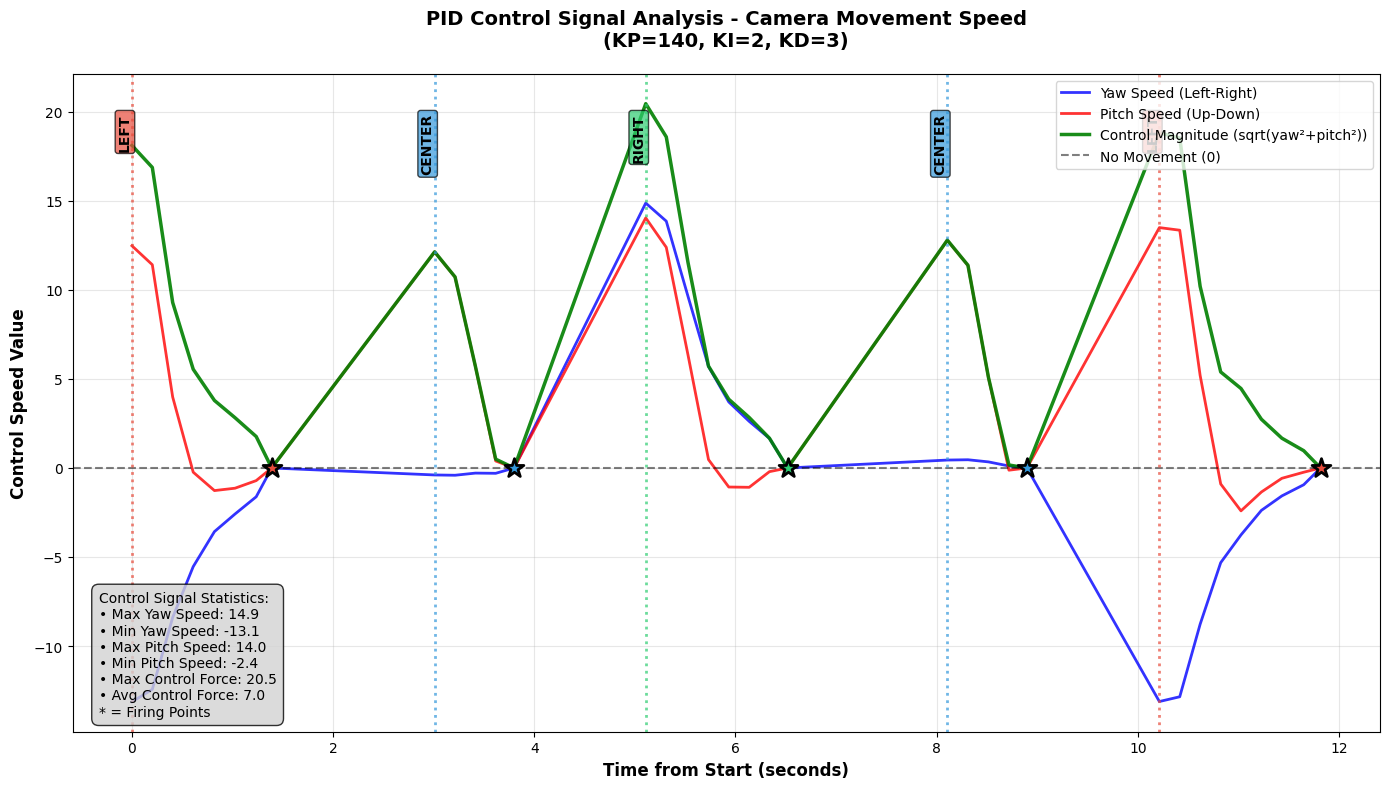

=== CONTROL SIGNAL ANALYSIS ===
PID Settings: KP=140, KI=2, KD=3
Analysis Period: 11.82 seconds

CONTROL INTENSITY:
• Yaw Speed Range: -13.14 to 14.88
• Pitch Speed Range: -2.41 to 14.05
• Average Control Magnitude: 6.98

STABILITY INDICATORS:
• Yaw Stability (σ): 6.47 (lower = more stable)
• Pitch Stability (σ): 5.81 (lower = more stable)
• Yaw Direction Changes: 9 times
• Pitch Direction Changes: 13 times

CAMERA SHAKE ASSESSMENT:
SMOOTH CONTROL: Minimal oscillation


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv(r'D:\downsyndrome\year2_1\Robot_Module_2-1\J.Thanet\Lab02\data\rec_track_1419_P140_I2_D3.csv')

# แปลง timestamp เป็น datetime และคำนวณเวลาสัมพันธ์
df['datetime'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
start_time = df['datetime'].iloc[0]
df['relative_time'] = (df['datetime'] - start_time).dt.total_seconds()

# คำนวณ control signal magnitude (ความรุนแรงรวม)
df['control_magnitude'] = np.sqrt(df['yaw_speed']**2 + df['pitch_speed']**2)

# กำหนดสีสำหรับแต่ละเป้าหมาย
target_colors = {'left': '#E74C3C', 'center': '#3498DB', 'right': '#2ECC71'}

# สร้างกราฟ
plt.figure(figsize=(14, 8))

# พลอต yaw_speed
plt.plot(df['relative_time'], df['yaw_speed'], 'b-', linewidth=2, alpha=0.8, label='Yaw Speed (Left-Right)')

# พลอต pitch_speed
plt.plot(df['relative_time'], df['pitch_speed'], 'r-', linewidth=2, alpha=0.8, label='Pitch Speed (Up-Down)')

# พลอต control magnitude
plt.plot(df['relative_time'], df['control_magnitude'], 'g-', linewidth=2.5, alpha=0.9, 
        label='Control Magnitude (sqrt(yaw²+pitch²))')

# เพิ่มเส้นอ้างอิงที่ y=0
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No Movement (0)')

# หาจุดที่มีการเปลี่ยนเป้าหมาย
target_changes = []
current_target = None
for i, row in df.iterrows():
    if current_target != row['target_name']:
        target_changes.append((row['relative_time'], row['target_name']))
        current_target = row['target_name']

# เพิ่มเส้นแบ่งเป้าหมาย
for i, (time, target) in enumerate(target_changes):
    plt.axvline(x=time, color=target_colors[target], linestyle=':', alpha=0.7, linewidth=2)
    plt.text(time, plt.ylim()[1]*0.9, f'{target.upper()}', 
            rotation=90, ha='right', va='top', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.2", facecolor=target_colors[target], alpha=0.7))

# เพิ่มจุดที่ยิงเป้า (fired=1)
fired_points = df[df['fired'] == 1]
for _, point in fired_points.iterrows():
    plt.scatter(point['relative_time'], 0, s=200, 
            color=target_colors[point['target_name']], 
            marker='*', edgecolor='black', linewidth=2, zorder=10)

# ตั้งค่ากราฟ
plt.xlabel('Time from Start (seconds)', fontsize=12, fontweight='bold')
plt.ylabel('Control Speed Value', fontsize=12, fontweight='bold')
plt.title('PID Control Signal Analysis - Camera Movement Speed\n(KP=140, KI=2, KD=3)', 
        fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# เพิ่มข้อมูลสถิติ
stats_text = f"""Control Signal Statistics:
• Max Yaw Speed: {df['yaw_speed'].max():.1f}
• Min Yaw Speed: {df['yaw_speed'].min():.1f}
• Max Pitch Speed: {df['pitch_speed'].max():.1f}
• Min Pitch Speed: {df['pitch_speed'].min():.1f}
• Max Control Force: {df['control_magnitude'].max():.1f}
• Avg Control Force: {df['control_magnitude'].mean():.1f}
* = Firing Points"""

plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
        fontsize=10, verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

# วิเคราะห์ความสั่นและความเสถียร
print("=== CONTROL SIGNAL ANALYSIS ===")
print(f"PID Settings: KP=140, KI=2, KD=3")
print(f"Analysis Period: {df['relative_time'].max():.2f} seconds")
print()

print("CONTROL INTENSITY:")
print(f"• Yaw Speed Range: {df['yaw_speed'].min():.2f} to {df['yaw_speed'].max():.2f}")
print(f"• Pitch Speed Range: {df['pitch_speed'].min():.2f} to {df['pitch_speed'].max():.2f}")
print(f"• Average Control Magnitude: {df['control_magnitude'].mean():.2f}")
print()

print("STABILITY INDICATORS:")
# คำนวณ standard deviation ของ control signals
yaw_std = df['yaw_speed'].std()
pitch_std = df['pitch_speed'].std()
print(f"• Yaw Stability (σ): {yaw_std:.2f} (lower = more stable)")
print(f"• Pitch Stability (σ): {pitch_std:.2f} (lower = more stable)")

# หาจำนวนครั้งที่เปลี่ยนเครื่องหมาย (การแกว่ง)
yaw_sign_changes = np.sum(np.diff(np.sign(df['yaw_speed'])) != 0)
pitch_sign_changes = np.sum(np.diff(np.sign(df['pitch_speed'])) != 0)
print(f"• Yaw Direction Changes: {yaw_sign_changes} times")
print(f"• Pitch Direction Changes: {pitch_sign_changes} times")
print()

print("CAMERA SHAKE ASSESSMENT:")
if yaw_std > 5 or pitch_std > 5:
    print("WARNING: HIGH SHAKE - Control signals are highly variable")
elif yaw_std > 2 or pitch_std > 2:
    print("CAUTION: MODERATE SHAKE - Some oscillation in control")
else:
    print("GOOD: LOW SHAKE - Stable control signals")

if yaw_sign_changes > 20 or pitch_sign_changes > 20:
    print("HIGH OSCILLATION: Frequent direction changes detected")
else:
    print("SMOOTH CONTROL: Minimal oscillation")